# Mini Projet SSL for Anomaly Detection

In [1]:
# Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import PIL
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import opendatasets as od
import kagglehub
import os
"""
# Create a directory to store the datasets
os.makedirs("datasets", exist_ok=True)

mvtec_ad_url = kagglehub.dataset_download("ipythonx/mvtec-ad")
auto_vi_url = "https://zenodo.org/api/records/10459003/files-archive"  

od.download(mvtec_ad_url, data_dir='datasets/MVTec_AD')
od.download(auto_vi_url, data_dir='datasets/AutoVI')
"""

### Chargement et prétraitement des images de MVTec AD

In [28]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mvtec_path = 'datasets/MVTec_AD'
categories = ['bottle', 'hazelnut', 'capsule', 'toothbrush']

def load_mvtec_images(category, split='train'):
    images = []
    labels = []
    
    split_path = os.path.join(mvtec_path, category, split)
    
    if split == 'train':
        good_path = os.path.join(split_path, 'good')
        for img_name in os.listdir(good_path):
            img_path = os.path.join(good_path, img_name)
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img)
            labels.append(0)
    
    else:
        for anomaly_type in os.listdir(split_path):
            anomaly_path = os.path.join(split_path, anomaly_type)
            for img_name in os.listdir(anomaly_path):
                img_path = os.path.join(anomaly_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = transform(img)
                images.append(img)
                
                if anomaly_type == 'good':
                    labels.append(0)
                else:
                    labels.append(1)

    return torch.stack(images), torch.tensor(labels)

train_images, train_labels = [], []
test_images, test_labels = [], []

for category in categories:
    imgs, lbls = load_mvtec_images(category, split='train')
    train_images.append(imgs)
    train_labels.append(lbls)
    
    imgs, lbls = load_mvtec_images(category, split='test')
    test_images.append(imgs)
    test_labels.append(lbls)

train_images = torch.cat(train_images)
train_labels = torch.cat(train_labels)
test_images = torch.cat(test_images)
test_labels = torch.cat(test_labels)

train_dataloader_MVTec = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_dataloader_MVTec = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from MVTec AD.")


Loaded 879 training images and 367 test images from MVTec AD.


### Chargement et prétraitement des images de AutoVI

In [29]:
autovi_path = 'datasets/AutoVI/engine_wiring'

# Function to load images from a specific split (train or test)
def load_autovi_images(split='train'):
    images = []
    labels = []
    
    # Define the path based on the split (train/test)
    split_path = os.path.join(autovi_path, split)
    
    # List all subfolders (categories)
    categories = os.listdir(split_path)
    
    for category in categories:
        category_path = os.path.join(split_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path).convert('RGB')  
            img = transform(img)  
            images.append(img)
            
            # Use the index of the category as a label (you can adjust this if needed)
            labels.append(categories.index(category))
    
    return torch.stack(images), torch.tensor(labels)  

# Load AutoVI dataset images (train and test)
train_images, train_labels = load_autovi_images(split='train')
test_images, test_labels = load_autovi_images(split='test')

# Create DataLoaders for AutoVI train and test sets
train_dataloader_auto = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_dataloader_auto = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

# Check loaded data
print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from AutoVI.")


Loaded 285 training images and 607 test images from AutoVI.


### Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.69411767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.7960784

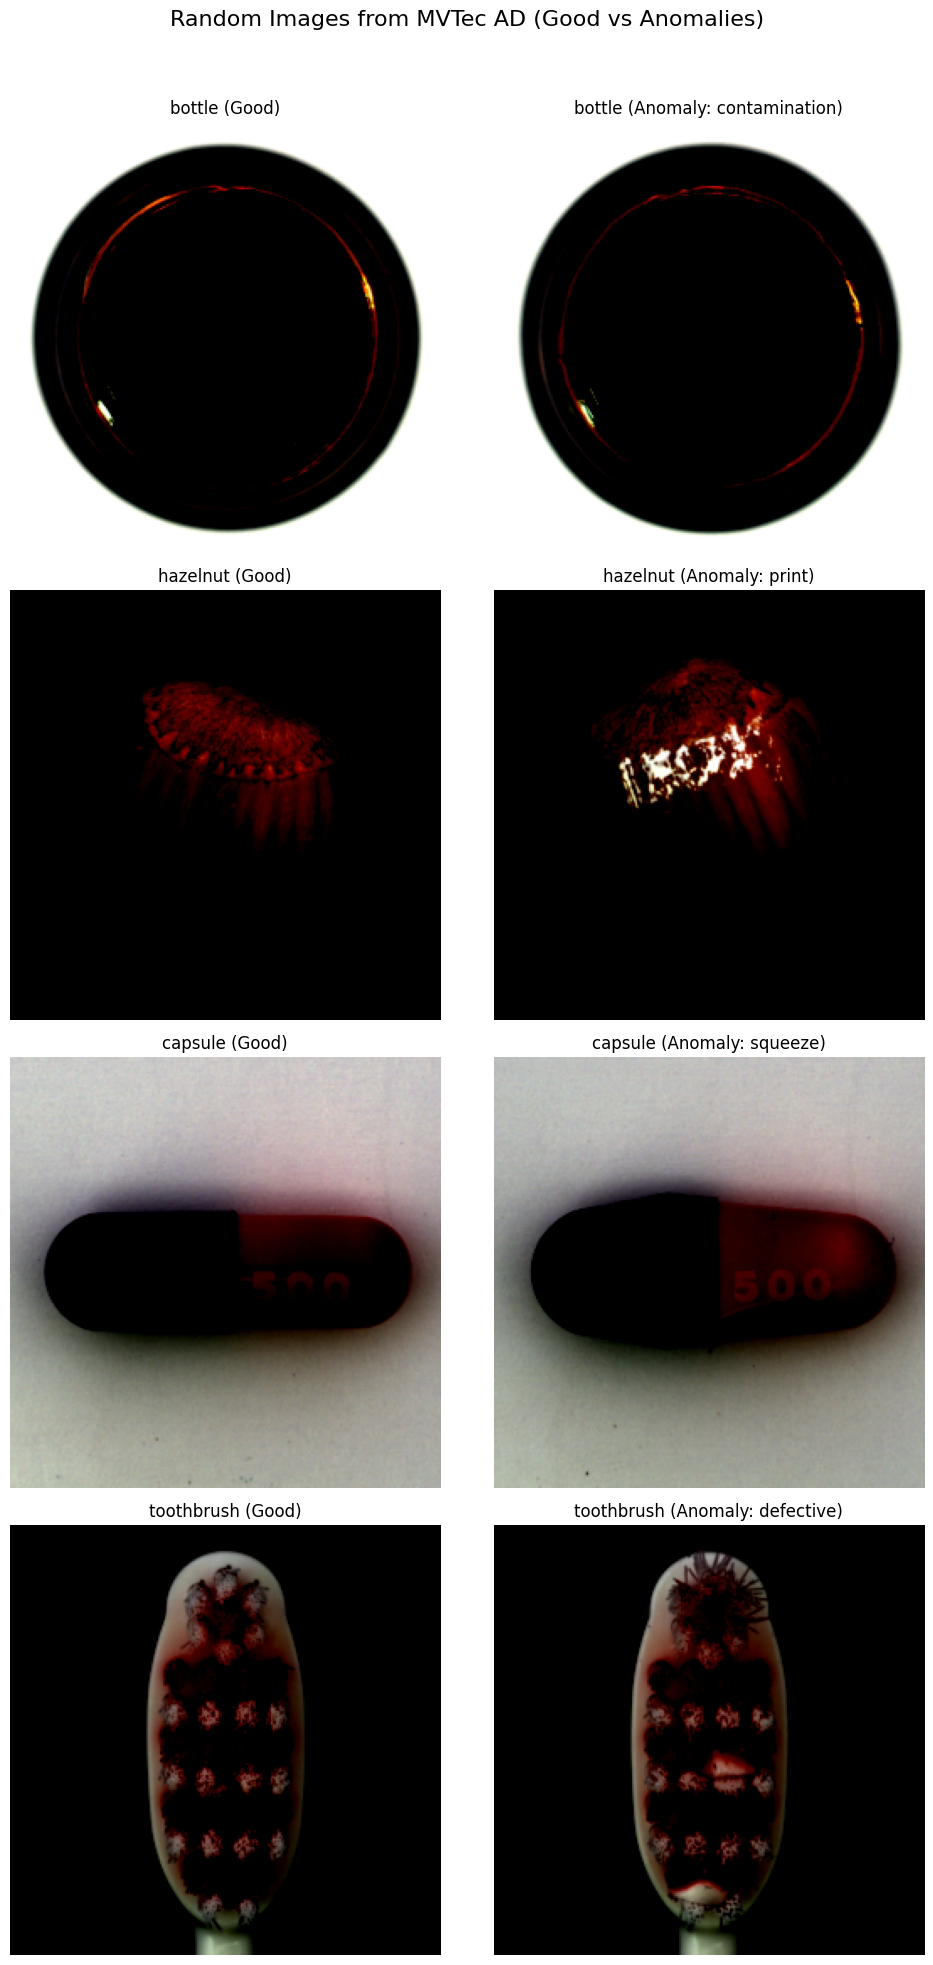

In [30]:
import random

def display_random__MVTec(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(len(category_list), 2, figsize=(10, 5 * len(category_list)))  
    fig.suptitle(f'Random Images from {dataset_name} (Good vs Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, category, split)
        
        # Load a random "good" image
        good_path = os.path.join(split_path, 'good')
        good_image = random.choice(os.listdir(good_path))
        good_image_path = os.path.join(good_path, good_image)
        img_good = Image.open(good_image_path).convert('RGB')
        img_good = transform(img_good)
        
        # Display the "good" image
        axs[i, 0].imshow(img_good.permute(1, 2, 0)) 
        axs[i, 0].set_title(f"{category} (Good)")
        axs[i, 0].axis('off')
        
        # Load a random anomalous image (choose a random anomaly type)
        anomalies = [d for d in os.listdir(split_path) if d != 'good']
        anomaly_type = random.choice(anomalies)
        anomaly_path = os.path.join(split_path, anomaly_type)
        anomaly_image = random.choice(os.listdir(anomaly_path))
        anomaly_image_path = os.path.join(anomaly_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        axs[i, 1].imshow(img_anomalous.permute(1, 2, 0))  
        axs[i, 1].set_title(f"{category} (Anomaly: {anomaly_type})")
        axs[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage for MVTec AD dataset
mvtec_path = 'datasets/MVTec_AD'
categories_mvtec = ['bottle', 'hazelnut', 'capsule', 'toothbrush']
display_random__MVTec(categories_mvtec, "MVTec AD", mvtec_path, transform, split='test')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


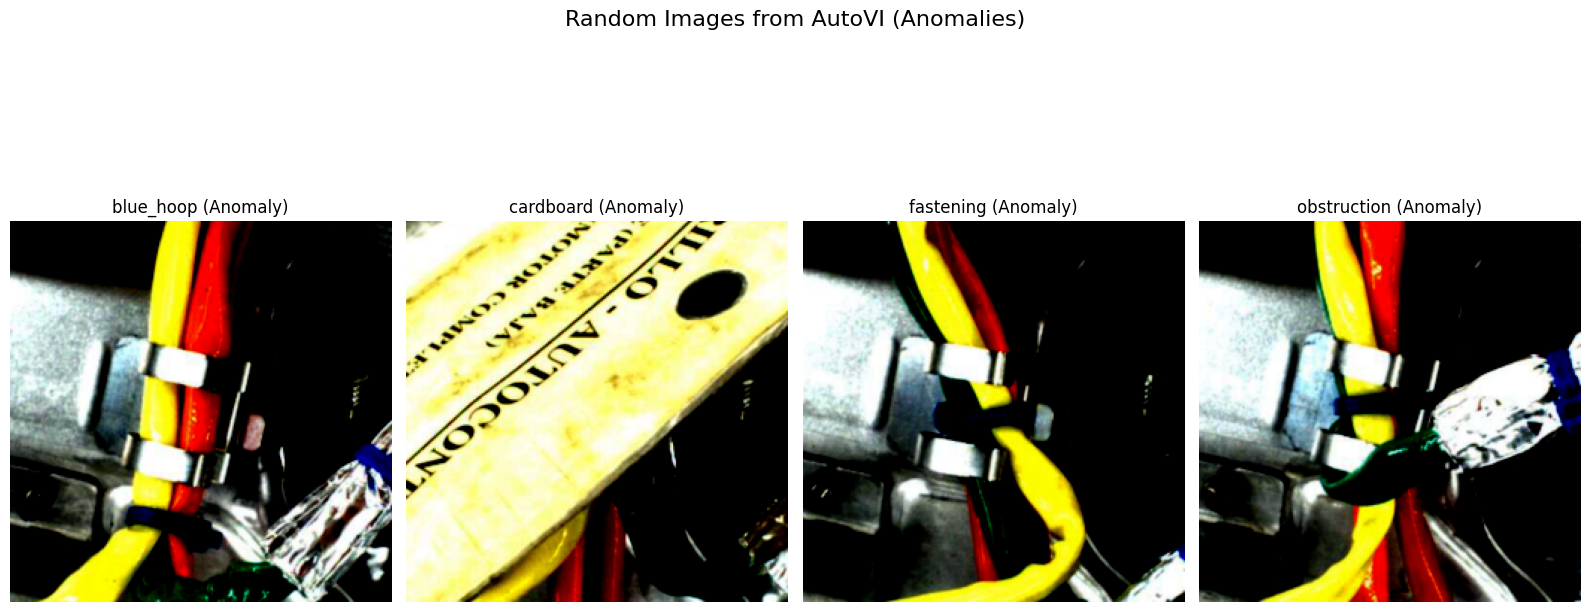

In [31]:
def display_random_autovi(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(1, len(category_list), figsize=(16, 8))  # Create subplot (1 row, 1 column per category)
    fig.suptitle(f'Random Images from {dataset_name} (Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, split, category)
        
        # Load a random anomalous image
        anomaly_image = random.choice(os.listdir(split_path))
        anomaly_image_path = os.path.join(split_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        axs[i].imshow(img_anomalous.permute(1, 2, 0))  # Rearrange dimensions for display
        axs[i].set_title(f"{category} (Anomaly)")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage for AutoVI dataset
autovi_path = 'datasets/AutoVI/engine_wiring'
categories_autovi = ['blue_hoop', 'cardboard', 'fastening', 'obstruction']  # Categories in AutoVI
display_random_autovi(categories_autovi, "AutoVI", autovi_path, transform, split='test')


### Masked AutoEncoder

In [32]:
class Encoder(nn.Module):
    def __init__(self, latent_dim,in_channels):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.encode(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1), 
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [35]:
# Define the Masked Autoencoder model
class MaskedAutoencoder(nn.Module):
    def __init__(self, mask_ratio, hidden_dim=1024):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim=hidden_dim, in_channels=3)  # Input grayscale
        self.decoder = Decoder(latent_dim=hidden_dim, out_channels=3)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        masked_x = self.apply_mask(x)
        encoded = self.encoder(masked_x)
        decoded = self.decoder(encoded)
        return decoded.view(batch_size, channels, height, width)

    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)  
        x_masked[mask] = 0
        return x_masked


In [84]:
from sklearn.metrics import roc_curve, auc
# Function to train the model
def train_model(model, dataloader, epochs, lr=0.001):
    criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

# Function to evaluate the model and calculate ROC-AUC
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.MSELoss(reduction='none')  # Use reduction='none' to compute loss per pixel
    losses = []
    labels = []
    seuil = 0.5
    with torch.no_grad():
        for images, lbls in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images).mean(dim=[1, 2, 3])  # Mean loss over pixels
            losses.extend(loss.cpu().numpy())
            binary_labels = [1 if label != 0 else 0 for label in lbls]
            labels.extend(binary_labels)
            
    # Appliquer le seuil pour classifier les images
    predicted_labels = [1 if loss > seuil else 0 for loss in losses]
    fpr, tpr, thresholds = roc_curve(labels, losses)

    accuracy = accuracy_score(labels, predicted_labels)
    print(f"Accuracy with threshold {seuil}: {accuracy:.4f}")
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Masked Autoencoder')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc



100%|██████████| 23/23 [00:00<00:00, 28.66it/s]

Accuracy with threshold 0.5: 0.5068


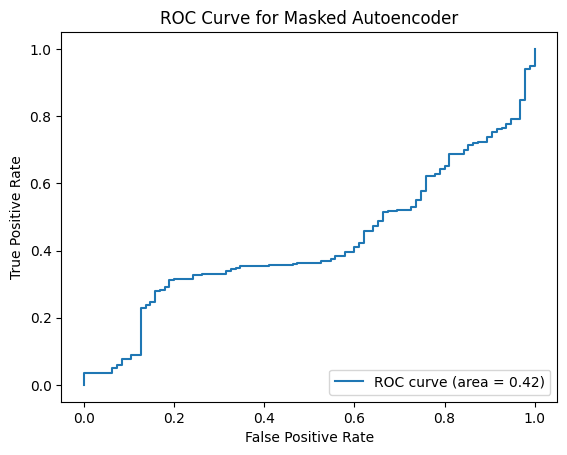

AUROC Score: 0.4243


In [85]:
# Assuming train_dataloader_MVTec and test_dataloader_MVTec are defined
# Initialize and train the model
mae_model_MV = MaskedAutoencoder(mask_ratio = 1/5).to(device)
train_model(mae_model_MV, train_dataloader_MVTec, epochs=5)
torch.save(mae_model_MV.state_dict(), 'Masked_Autoencoder_MVTec_weights.pth')
# Evaluate the model
roc_auc = evaluate_model(mae_model_MV, test_dataloader_MVTec)



print(f"AUROC Score: {roc_auc:.4f}")

100%|██████████| 38/38 [00:01<00:00, 30.31it/s]


Accuracy with threshold 0.5: 0.0082


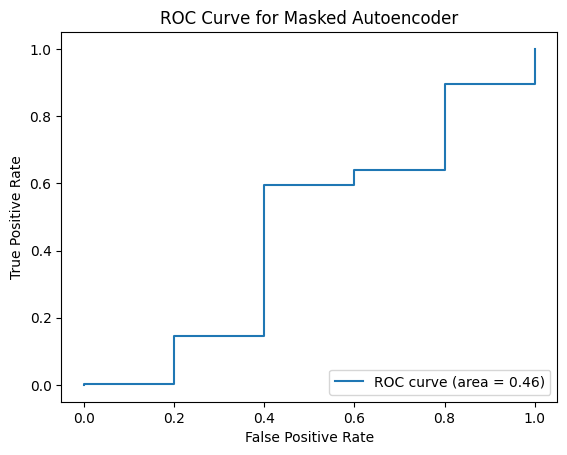

AUROC Score: 0.4561


In [86]:
# Assuming train_dataloader_MVTec and test_dataloader_MVTec are defined
# Initialize and train the model
from sklearn.metrics import roc_auc_score

mae_model_auto = MaskedAutoencoder(mask_ratio = 1/5).to(device)
train_model(mae_model_auto, train_dataloader_auto, epochs=5)
torch.save(mae_model_auto.state_dict(), 'Masked_Autoencoder_AUTO_weights.pth')
# Evaluate the model
roc_aucs = evaluate_model(mae_model_auto, test_dataloader_auto)

print(f"AUROC Score: {roc_aucs:.4f}")

### Contrastive Model

In [200]:
class ContrastiveModel(nn.Module):
    def __init__(self):
        super(ContrastiveModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1)
        )
        self.fc = nn.Linear(64 * 27 * 27, 64)  # Ajusté en fonction de la sortie des convolutions

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir les données
        x = self.fc(x)
        return x


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, z1, z2, label):
        euclidean_distance = nn.functional.pairwise_distance(z1, z2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + 
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss



In [205]:
import random

def generate_contrastive_pairs(batch_images, batch_labels):
    pairs = []
    pair_labels = []
    
    batch_size = len(batch_images)
    
    for i in range(batch_size):
        # Générer une paire positive (même classe)
        positive_indices = [j for j in range(batch_size) if batch_labels[i] == batch_labels[j]]
        if len(positive_indices) > 1:  # Vérifier qu'il y a au moins une autre image de la même classe
            positive_index = random.choice([j for j in positive_indices if j != i])
            pairs.append((batch_images[i], batch_images[positive_index]))
            pair_labels.append(1)  # Label 1 pour paire positive
        
        # Générer une paire négative (classe différente)
        negative_indices = [j for j in range(batch_size) if batch_labels[i] != batch_labels[j]]
        if len(negative_indices) > 0:  # Vérifier qu'il y a au moins une image d'une classe différente
            negative_index = random.choice(negative_indices)
            pairs.append((batch_images[i], batch_images[negative_index]))
            pair_labels.append(0)  # Label 0 pour paire négative

    # Convertir en tenseurs
    if pairs:  # Vérifier si des paires ont été générées
        pair1, pair2 = zip(*pairs)
        return (torch.stack(pair1), torch.stack(pair2)), torch.tensor(pair_labels)
    else:
        raise ValueError("Aucune paire n'a pu être générée dans ce batch.")


In [206]:
# Fonction d'entraînement pour le modèle contrastif
def train_contrastive_model(model, dataloader, epochs, lr=0.001, weight_decay=1e-4, patience=2):
    criterion = nn.CosineEmbeddingLoss()  # Utilise la perte de similarité cosinus
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.to(device)
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for batch_images, batch_labels in tqdm(dataloader):
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Générer des paires contrastives
            pairs, pair_labels = generate_contrastive_pairs(batch_images, batch_labels)

            # Obtenir les représentations latentes des deux images dans la paire
            z1 = model(pairs[0].to(device))  # Appliquer .to(device) à chaque image
            z2 = model(pairs[1].to(device))

            optimizer.zero_grad()

            # Calculer la perte contrastive (CosineEmbeddingLoss)
            loss = criterion(z1, z2, pair_labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_images.size(0)
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # Early Stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [211]:
def evaluate_contrastive_model(model, dataloader):
    model.eval()
    distances = []
    labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in tqdm(dataloader):
            pairs, pair_labels = generate_contrastive_pairs(batch_images, batch_labels)
            z1 = model(pairs[0].to(device))
            z2 = model(pairs[1].to(device))
            euclidean_distance = nn.functional.pairwise_distance(z1, z2)
            distances.extend(euclidean_distance.cpu().numpy())
            labels.extend(pair_labels.cpu().numpy())
    
    fpr, tpr, thresholds = roc_curve(labels, distances)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Contrastive Model')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc


100%|██████████| 55/55 [00:03<00:00, 17.08it/s]


Epoch [1/2], Loss: 0.0778
Epoch [1/2], Loss: 0.0778


100%|██████████| 55/55 [00:02<00:00, 20.90it/s]


Epoch [2/2], Loss: 0.0003
Epoch [2/2], Loss: 0.0003


100%|██████████| 23/23 [00:00<00:00, 41.39it/s]


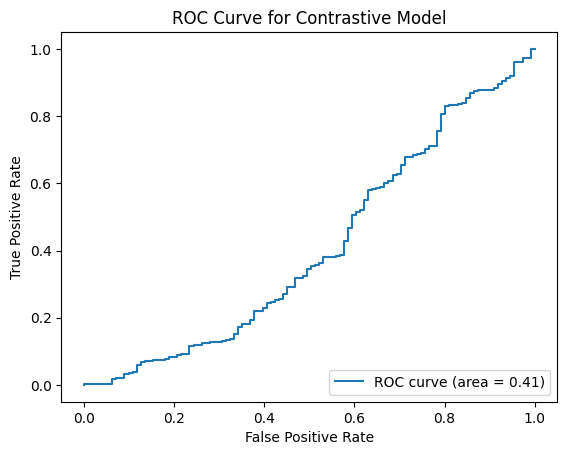

AUROC Score: 0.4096884


In [212]:
contrastive_model = ContrastiveModel().to(device)
train_contrastive_model(contrastive_model, train_dataloader_MVTec, epochs=2)

roc_auc_score = evaluate_contrastive_model(contrastive_model, test_dataloader_MVTec)
print(f"AUROC Score: {roc_auc_score:.7f}")


100%|██████████| 23/23 [00:00<00:00, 51.01it/s]


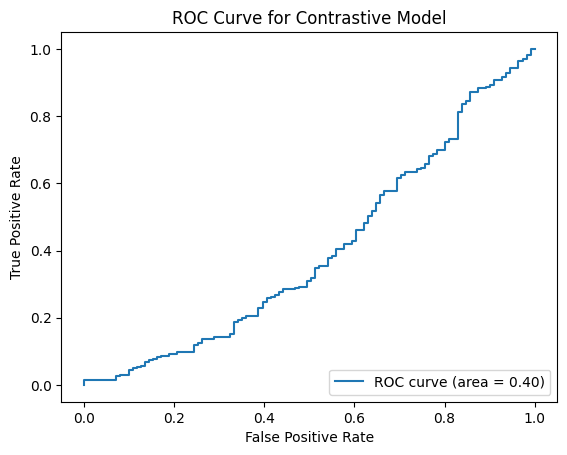

AUROC Score: 0.3995


In [213]:
roc_auc_score = evaluate_contrastive_model(contrastive_model, test_dataloader_MVTec)
print(f"AUROC Score: {roc_auc_score:.4f}")